In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [71]:
DEBUG = True
MAX_DEPTH_TUNNING_PLOT = False
K_FOLD_CROSS_VALIDATION = False

In [72]:
# Load the features 
X = pd.read_csv("features.csv")
X
#X.describe()

,BASEMENT AIR NODE:System Node Temp[C](TimeStep),CORE_BOTTOM AIR NODE:System Node Temp[C](TimeStep),CORE_MID AIR NODE:System Node Temp[C](TimeStep),CORE_TOP AIR NODE:System Node Temp[C](TimeStep),PERIMETER_BOT_ZN_1 AIR NODE:System Node Temp[C](TimeStep),PERIMETER_BOT_ZN_2 AIR NODE:System Node Temp[C](TimeStep),PERIMETER_BOT_ZN_3 AIR NODE:System Node Temp[C](TimeStep),PERIMETER_BOT_ZN_4 AIR NODE:System Node Temp[C](TimeStep),PERIMETER_MID_ZN_1 AIR NODE:System Node Temp[C](TimeStep),PERIMETER_MID_ZN_2 AIR NODE:System Node Temp[C](TimeStep),PERIMETER_MID_ZN_3 AIR NODE:System Node Temp[C](TimeStep),PERIMETER_MID_ZN_4 AIR NODE:System Node Temp[C](TimeStep),PERIMETER_TOP_ZN_1 AIR NODE:System Node Temp[C](TimeStep),PERIMETER_TOP_ZN_2 AIR NODE:System Node Temp[C](TimeStep),PERIMETER_TOP_ZN_3 AIR NODE:System Node Temp[C](TimeStep),PERIMETER_TOP_ZN_4 AIR NODE:System Node Temp[C](TimeStep),Environment:Wind Speed [m/s](TimeStep),Environment:Direct Solar [W/m2](TimeStep)
0,19.862087,16.963046,15.622112,15.551921,15.502212,15.462466,15.469208,15.461811,15.446735,15.399978,15.406186,15.403479,15.378094,15.327348,15.335819,15.330549,3.933333,0.000000
1,21.913795,22.044001,21.863447,21.002707,23.319969,20.999086,21.001217,21.003907,22.898097,21.002758,21.005249,20.996894,21.830386,21.004004,21.000801,20.999416,1.866667,614.166667
2,21.914443,22.045963,21.866014,21.003439,23.427551,21.004040,21.003266,21.000108,23.051426,21.002707,21.001339,21.004825,21.985028,21.007795,20.999167,21.005491,1.683333,603.333333
3,21.915154,22.047681,21.868481,21.004403,23.518481,21.000991,21.002051,21.001697,23.190456,20.998284,21.002578,20.997406,22.127905,21.004721,21.001139,20.996942,1.500000,592.500000
4,21.915918,22.049130,21.870792,21.001621,23.595979,20.997118,21.001625,21.000394,23.297264,20.999808,21.002541,20.996497,22.233139,21.004091,21.001997,21.006679,1.850000,581.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43258,21.911762,22.034182,21.853714,21.003348,22.394698,21.008423,20.999403,20.999064,21.805884,20.999413,21.002570,20.995806,21.000716,20.998894,21.000484,21.004545,2.600000,607.666667
43259,21.912003,22.035553,21.854514,21.002985,22.615771,21.001370,20.999834,20.999521,22.047777,21.003865,21.004274,20.998091,21.025106,20.998671,21.001177,21.005970,2.600000,612.000000
43260,21.912324,22.037202,21.855930,21.002206,22.811730,20.998301,21.001778,21.002657,22.274239,21.000588,21.001380,21.005093,21.226789,20.995749,21.000287,21.007607,2.416667,616.333333
43261,21.912730,22.039724,21.858485,21.002352,23.003805,20.998746,21.002707,20.997488,22.500722,21.004161,21.002877,21.009400,21.437357,21.001401,21.001210,21.007037,2.233333,620.666667


In [73]:
# Load the labels
y = pd.read_csv("consumption.csv", header=None)
y
#y.describe()

,0
0,172281539.6
1,415997102.9
2,415998206.4
3,415998840.3
4,415998040.6
...,...
43258,415994184.8
43259,415992791.4
43260,415994598.2
43261,415995514.3


In [74]:
# Split the dataset - train test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [75]:
# Instantiate and fit Decision Tree Regressor
regressor = DecisionTreeRegressor(max_depth=18,
                                  min_samples_split=40)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=18, min_samples_split=40)

In [76]:
# Predict on test data
y_pred = regressor.predict(X_test)

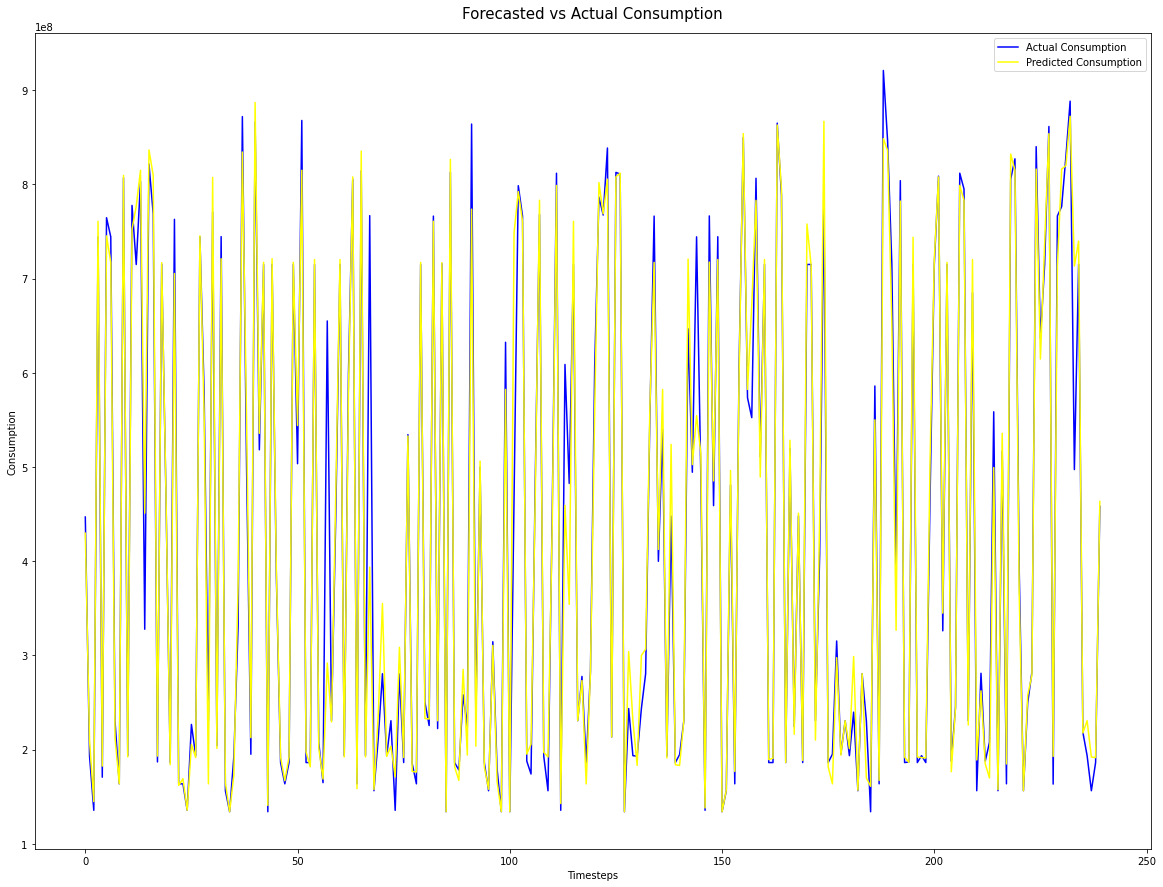

In [77]:
# Plot Actual and Predicted values for the first 240 timesteps
def cmp_prediction():
    import itertools
    
    y_test_arr = list(itertools.chain(*y_test.values)) #convert dataframe to array

    # Compare y and y^ 
    df_cmp = pd.DataFrame({'Actual':y_test_arr, 'Predicted':y_pred})    
    
    return df_cmp
    
if DEBUG:
    df_cmp = cmp_prediction().head(240)
    df_cmp['Actual']

    import matplotlib.pyplot as plt

    timesteps = range(0, 240)
    plt.figure(figsize=(20,15)) 
    plt.plot(timesteps, df_cmp['Actual'], color='blue', label='Actual Consumption')
    plt.plot(timesteps, df_cmp['Predicted'], color='yellow', label='Predicted Consumption')
    plt.xlabel('Timesteps')
    plt.ylabel('Consumption')
    plt.title('Forecasted vs Actual Consumption', pad=15, size=15)
    plt.legend()

    plt.savefig('forecast_240.jpg')

In [78]:
# Calculate and print the Mean Absolute Error and Mean Squared Error
def calc_MSE_MAE(y_test, y_pred):
    print('MSE:', mse(y_test, y_pred))
    print('MAE:', mae(y_test, y_pred))

calc_MSE_MAE(y_test, y_pred)

MSE: 3233714995863993.5
MAE: 27170035.103218492


In [79]:
if MAX_DEPTH_TUNNING_PLOT:
    import matplotlib.pyplot as plt

    max_depths = range(5, 20)
    training_error = []
    for max_depth in max_depths:
        model_1 = DecisionTreeRegressor(max_depth=max_depth)
        model_1.fit(X, y)
        e = mse(y, model_1.predict(X))
        training_error.append(e)

    testing_error = []
    for max_depth in max_depths:
        model_2 = DecisionTreeRegressor(max_depth=max_depth)
        model_2.fit(X_train, y_train)
        testing_error.append(mse(y_test, model_2.predict(X_test)))

    plt.figure(figsize=(10,5)) 
    plt.plot(max_depths, training_error, color='blue', label='Training error')
    plt.plot(max_depths, testing_error, color='green', label='Testing error')
    plt.xlabel('Tree depth')
    plt.axvline(x=13, color='orange', linestyle='--')
    plt.annotate('optimum = 13', xy=(14, 6e+15), color='red')
    plt.ylabel('Mean squared error')
    plt.title('Hyperparameter Tuning - Max_Depth', pad=15, size=15)
    plt.legend()

    plt.savefig('error.png')

In [80]:
if K_FOLD_CROSS_VALIDATION:
    from sklearn.model_selection import GridSearchCV

    model = DecisionTreeRegressor()

    gs = GridSearchCV(model,
                      param_grid = {'max_depth': range(10, 20),
                                    'min_samples_split': range(10, 60, 10)},
                      cv=5,
                      n_jobs=1,
                      scoring='neg_mean_squared_error')

    gs.fit(X_train, y_train)

    print(gs.best_params_)
    print(-gs.best_score_)